In [79]:
import warnings
warnings.filterwarnings('ignore')

from gensim.models.wrappers import FastText
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pickle

import pandas as pd
import numpy as np
from enum import Enum
import itertools
from collections import defaultdict
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 20, 7

## Load the clean and the dirty dataset

In [2]:
df = pd.read_csv('HospitalErrors.csv', encoding='utf8', dtype=object)

In [3]:
df.head(2)

,ProviderNumber,HospitalName,Address1,City,ZipCode,CountyName,PhoneNumber,HospitalOwner,Condition,Sample,label
0,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,35235,JEFFERSON,2058383122,Voluntary non-profit - Private,Pneumonia,112 patients,0
1,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,35007,SHELBY,2056208100,Voluntary non-profit - Church,Surgical Infection Prevention,368 patients,0


In [4]:
len(df)

748

In [5]:
sum(df.isnull().values.ravel())

275

In [6]:
dfEmpty = df[df.isnull().any(axis=1)]

In [11]:
len(dfEmpty)

275

In [12]:
dfEmpty.drop(columns=['label'], axis=1, inplace=True)

In [13]:
dfEmpty.head(2)

,ProviderNumber,HospitalName,Address1,City,ZipCode,CountyName,PhoneNumber,HospitalOwner,Condition,Sample
232,10007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,36467,COVINGTON,3344933541,Voluntary non-profit - Private,Surgical Infection Prevention,NaN
233,20017,ALASKA REGIONAL HOSPITAL,2801 DEBARR ROAD,ANCHORAGE,99508,ANCHORAGE,9072761131,Proprietary,Pneumonia,NaN


## Word2Vec Model

In [14]:
path = 'HospitalMultiAttributeWord2Vec.w2v'
word2vecModel = KeyedVectors.load(path)

In [15]:
class Attributes(Enum):
    ProviderNumber = 1
    HospitalName = 2
    Address1 = 3
    City = 4
    ZipCode = 5
    CountyName = 6
    PhoneNumber = 7
    HospitalOwner = 8
    Condition = 9
    Sample = 10

In [16]:
attributeMapping = {}
attributeMapping["ProviderNumber"] = Attributes.ProviderNumber
attributeMapping["HospitalName"] = Attributes.HospitalName
attributeMapping["Address1"] = Attributes.Address1
attributeMapping["City"] = Attributes.City
attributeMapping["ZipCode"] = Attributes.ZipCode
attributeMapping["CountyName"] = Attributes.CountyName
attributeMapping["PhoneNumber"] = Attributes.PhoneNumber
attributeMapping["HospitalOwner"] = Attributes.HospitalOwner
attributeMapping["Condition"] = Attributes.Condition
attributeMapping["Sample"] = Attributes.Sample

In [17]:
attributeMapping

{'Address1': <Attributes.Address1: 3>,
 'City': <Attributes.City: 4>,
 'Condition': <Attributes.Condition: 9>,
 'CountyName': <Attributes.CountyName: 6>,
 'HospitalName': <Attributes.HospitalName: 2>,
 'HospitalOwner': <Attributes.HospitalOwner: 8>,
 'PhoneNumber': <Attributes.PhoneNumber: 7>,
 'ProviderNumber': <Attributes.ProviderNumber: 1>,
 'Sample': <Attributes.Sample: 10>,
 'ZipCode': <Attributes.ZipCode: 5>}

In [18]:
inverseMapping = {y:x for x,y in attributeMapping.items()}

In [19]:
inverseMapping

{<Attributes.Address1: 3>: 'Address1',
 <Attributes.City: 4>: 'City',
 <Attributes.Condition: 9>: 'Condition',
 <Attributes.CountyName: 6>: 'CountyName',
 <Attributes.HospitalName: 2>: 'HospitalName',
 <Attributes.HospitalOwner: 8>: 'HospitalOwner',
 <Attributes.PhoneNumber: 7>: 'PhoneNumber',
 <Attributes.ProviderNumber: 1>: 'ProviderNumber',
 <Attributes.Sample: 10>: 'Sample',
 <Attributes.ZipCode: 5>: 'ZipCode'}

Load Model

In [20]:
model = load_model('HospitalMultiAttributeClassifier.h5')

Load tokenizer

In [21]:
with open('HospitalMultiAttributeClassifierTokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [22]:
mapping = {0: 'Address1',
 1: 'City',
 2: 'Condition',
 3: 'CountyName',
 4: 'HospitalName',
 5: 'HospitalOwner',
 6: 'PhoneNumber',
 7: 'ProviderNumber',
 8: 'Sample',
 9: 'ZipCode'}

## Prediction pipeline

In [23]:
def impute(word2vecModel, model, tokenizer, rowWithMissingValue, missingType, topN=10):
    """
    Returns the closest match for the missing attribute value
    """
    output = dict()
    for value in rowWithMissingValue:
        try:
            results = word2vecModel.wv.most_similar(value, topn=topN)
            for match, confidence in results:
                # Predicted type to be equal to the missing value
                if predictAttribute(model, tokenizer, match) == missingType:
                    if match in output and confidence <= output[match]:
                        continue
                    else:
                        output[match] = confidence            
        except KeyError:
            continue
    return output.items()

In [24]:
def predictAttribute(model, tokenizer, value):
    """
    Classifies value parameter as its corresponding attribute
    """
    value = [value]
    sequences = tokenizer.texts_to_sequences(value)
    testData = pad_sequences(sequences, maxlen=45)
    predictions = model.predict(testData)
    return attributeMapping[mapping[np.argmax(predictions[0])]]

Convert each row to a list

In [25]:
nullRows = dfEmpty.values.tolist()

Create a mapping of the form **row: missingAttribute**

In [26]:
rows = []
columnNames = ['ProviderNumber', 'HospitalName', 'Address1', 'City', 'ZipCode', 'CountyName', 'PhoneNumber','HospitalOwner','Condition','Sample']
for row in nullRows:
    missingAttribute = None
    removedNan = []
    for i in range(len(row)):
        if str(row[i]) != 'nan' and str(row[i]) != '0':
            removedNan.append(row[i])
        else:
            missingAttribute = attributeMapping[columnNames[i]]
    if missingAttribute is not None:
        rows.append({tuple(removedNan):missingAttribute})
    else:
        print(row)

## Perform imputation

In [27]:
def getImputedValue(missingRow, attributeType):
    results = impute(word2vecModel, model, tokenizer, missingRow, attributeType, 25)
    return sorted(results, key=lambda x: x[1], reverse=True)[0] if results else None

### Build the verfication pipeline

In [28]:
dfClean = pd.read_csv('clean_hosp_dataset.csv', encoding='utf8', dtype='object')

In [29]:
len(dfClean)

826

In [30]:
dfUnique = dfClean.drop_duplicates()

In [31]:
len(dfUnique)

824

In [32]:
dfUnique.head(2)

,ProviderNumber,HospitalName,Address1,City,ZipCode,CountyName,PhoneNumber,HospitalOwner,Condition,Sample
0,10018,CALLAHAN EYE FOUNDATION HOSPITAL,1720 UNIVERSITY BLVD,BIRMINGHAM,35233,JEFFERSON,2053258100,Voluntary non-profit - Private,Surgical Infection Prevention,0 patients
1,10019,HELEN KELLER MEMORIAL HOSPITAL,1300 SOUTH MONTGOMERY AVENUE,SHEFFIELD,35660,JEFFERSON,2563864556,Government - Hospital District or Authority,Heart Attack,33 patients


In [33]:
queryMapping = {
    Attributes.ProviderNumber : 'HospitalName=="{}" and Address1=="{}" and City=="{}" and ZipCode=="{}" and CountyName=="{}"and PhoneNumber=="{}" and HospitalOwner == "{}" and Condition == "{}" and Sample=="{}"',
    Attributes.HospitalName : 'ProviderNumber=="{}" and Address1=="{}" and City=="{}" and ZipCode=="{}" and CountyName=="{}"and PhoneNumber=="{}" and HospitalOwner == "{}" and Condition == "{}" and Sample=="{}"',
    Attributes.Address1 : 'ProviderNumber=="{}" and HospitalName=="{}" and City=="{}" and ZipCode=="{}" and CountyName=="{}"and PhoneNumber=="{}" and HospitalOwner == "{}" and Condition == "{}" and Sample=="{}"',
    Attributes.City : 'ProviderNumber=="{}" and HospitalName=="{}" and Address1=="{}" and ZipCode=="{}" and CountyName=="{}"and PhoneNumber=="{}" and HospitalOwner == "{}" and Condition == "{}" and Sample=="{}"',
    Attributes.ZipCode : 'ProviderNumber=="{}" and HospitalName=="{}" and Address1=="{}" and City=="{}" and CountyName=="{}"and PhoneNumber=="{}" and HospitalOwner == "{}" and Condition == "{}" and Sample=="{}"',
    Attributes.CountyName : 'ProviderNumber=="{}" and HospitalName=="{}" and Address1=="{}" and City=="{}" and ZipCode=="{}" and PhoneNumber=="{}" and HospitalOwner == "{}" and Condition == "{}" and Sample=="{}"',
    Attributes.PhoneNumber : 'ProviderNumber=="{}" and HospitalName=="{}" and Address1=="{}" and City=="{}" and ZipCode=="{}" and CountyName=="{}" and HospitalOwner == "{}" and Condition == "{}" and Sample=="{}"',
    Attributes.HospitalOwner : 'ProviderNumber=="{}" and HospitalName=="{}" and Address1=="{}" and City=="{}" and ZipCode=="{}" and CountyName=="{}" and PhoneNumber=="{}" and Condition == "{}" and Sample=="{}"',
    Attributes.Condition : 'ProviderNumber=="{}" and HospitalName=="{}" and Address1=="{}" and City=="{}" and ZipCode=="{}" and CountyName=="{}"and PhoneNumber=="{}" and HospitalOwner == "{}" and Sample=="{}"',
    Attributes.Sample : 'ProviderNumber=="{}" and HospitalName=="{}" and Address1=="{}" and City=="{}" and ZipCode=="{}" and CountyName=="{}"and PhoneNumber=="{}" and HospitalOwner == "{}" and Condition == "{}"',
}


In [34]:
correct = 0
inCorrect = 0
incorrectPredictions = []

In [35]:
for row in rows:
    missingRow = list(row.keys())[0]
    attribute = list(row.values())[0]

    missingRow = [i.strip() for i in missingRow]
    # Run the query
    query = (queryMapping[attribute]).format(*missingRow)
    outputDf = dfClean.query(query)
    actual = outputDf.head(1)[inverseMapping[attribute]].to_string(index=False)
    
    predicted = getImputedValue(missingRow, attribute)       
    if predicted and actual == predicted[0]:
        correct += 1
    else:
        inCorrect += 1
        incorrectPredictions.append((actual, predicted[0] if predicted else None))       
        

In [36]:
correct

190

In [37]:
inCorrect

85

In [38]:
incorrectPredictions

[('11 patients', '100 patients'),
 ('37 patients', '223 patients'),
 ('509 patients', '561 patients'),
 ('Heart Failure', None),
 ('Heart Failure', None),
 ('BIRMINGHAM', 'FRANKLIN'),
 ('Heart Failure', None),
 ('Heart Attack', None),
 ('54 patients', '144 patients'),
 ('172 patients', '167 patients'),
 ('Proprietary', None),
 ('Pneumonia', None),
 ('23 patients', '195 patients'),
 ('Voluntary non-profit - Private', None),
 ('Government - Hospital District or Authority', None),
 ('Voluntary non-profit - Other', None),
 ('Voluntary non-profit - Private', 'Government - Local'),
 ('10 patients', '78 patients'),
 ('MONTGOMERY', None),
 ('Pneumonia', None),
 ('Proprietary', None),
 ('Voluntary non-profit - Other', None),
 ('Surgical Infection Prevention', None),
 ('Government - Hospital District or Authority', None),
 ('1 patients', '21 patients'),
 ('Surgical Infection Prevention', None),
 ('Government - Hospital District or Authority', None),
 ('114 patients', '1016 patients'),
 ('Volunta

In [39]:
accuracy = correct / (correct + inCorrect) * 1.0

In [40]:
accuracy

0.6909090909090909

In [59]:
errorAnalysis = defaultdict(int)
for actual, predicted in incorrectPredictions:
    errorAnalysis[predictAttribute(model, tokenizer, actual)] += 1

In [80]:
errorAnalysis

defaultdict(int,
            {<Attributes.City: 4>: 3,
             <Attributes.Condition: 9>: 26,
             <Attributes.CountyName: 6>: 1,
             <Attributes.HospitalOwner: 8>: 28,
             <Attributes.Sample: 10>: 27})

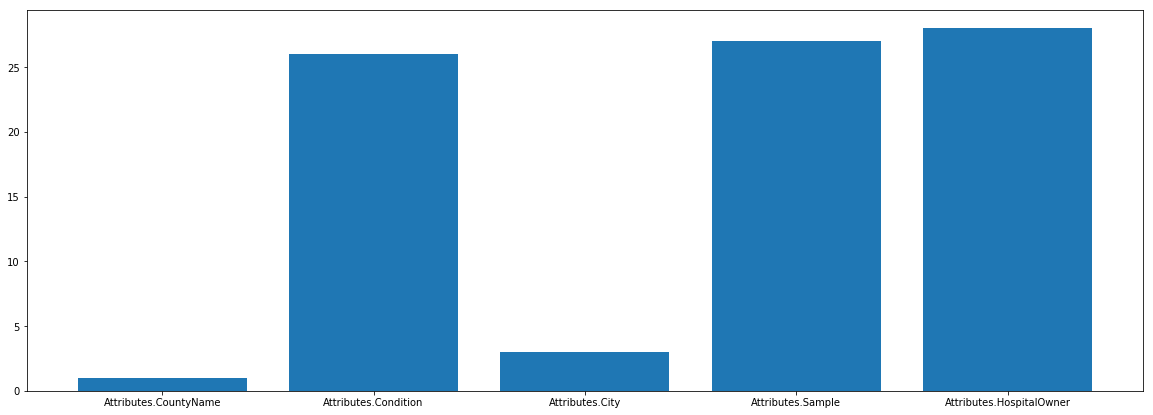

In [81]:
plt.bar(range(len(errorAnalysis)), list(errorAnalysis.values()), align='center')
plt.xticks(range(len(errorAnalysis)), list(errorAnalysis.keys()))
plt.show()